In [1]:
import os
import sys
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')

In [13]:
from dask.distributed import Client
C = Client()
C

Client Scheduler: tcp://127.0.0.1:49759 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [2]:
def total_bmb(avg,grd,vostock,time_slice):
    
    s2a = 3600*24*365.25
    rhoi = 916

    mask = (grd.mask_rho == 1 )& (grd.zice < 0)
    mask[vostock[0],vostock[1]] = False

    dA = (1/(grd.pm*grd.pn)).where(mask)
    weights = dA/dA.sum()
    
    ismr = (avg.m.sel(ocean_time=time_slice).where(mask)*weights*s2a).sum(['xi_rho','eta_rho'])
    bmb = (avg.m.sel(ocean_time=time_slice).where(mask)*dA*rhoi*(10**-12)*s2a).sum(['xi_rho','eta_rho'])
    
    return bmb,ismr,mask

In [7]:
grd10_path = os.path.join(data_dir,'raw','waom_frc','waom10_grd.nc')
waom10_path = os.path.join(data_dir,'raw','waom10','ocean_avg_00??.nc')
vostock10 = [np.arange(200,260),np.arange(400,480)]
time = slice('2007','2015')

avg10 = xr.open_mfdataset(waom10_path)
grd10 = xr.open_dataset(grd10_path)

bmb10,ismr10,mask10 = total_bmb(avg10,grd10,vostock10,time)

In [9]:
grd4_path = os.path.join(data_dir,'raw','waom_frc','waom4_grd.nc')
waom4_path = os.path.join(data_dir,'raw','waom4','ocean_avg_00??.nc')
vostock4 = [np.arange(500,650),np.arange(1000,1200)]
time = slice('2007','2015')

avg4 = xr.open_mfdataset(waom4_path)
grd4 = xr.open_dataset(grd4_path)

bmb4,ismr4,mask4 = total_bmb(avg4,grd4,vostock4,time)

In [14]:
grd2_path = os.path.join(data_dir,'raw','waom_frc','waom2_grd.nc')
waom2_path = os.path.join(data_dir,'raw','waom2','ocean_avg_0[5,6]??.nc')
vostock2 = [np.arange(1000,1300),np.arange(2000,2400)]
time = slice('2014','2015')

avg2 = xr.open_mfdataset(waom2_path)
grd2 = xr.open_dataset(grd2_path)

bmb2,ismr2,mask2 = total_bmb(avg2.resample(ocean_time='1MS').mean(),grd2,vostock2,time)

In [15]:
ismr2

<xarray.DataArray (ocean_time: 14)>
dask.array<shape=(14,), dtype=float64, chunksize=(1,)>
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-04-01 2014-05-01 2014-06-01 ...

In [24]:
ismr2.ocean_time.values = ismr4.sel(ocean_time=slice('2014-4','2015-4')).ocean_time
ismr2.ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 13)>
array(['2014-04-15T11:00:00.000000000', '2014-05-15T21:00:00.000000000',
       '2014-06-15T07:00:00.000000000', '2014-07-15T17:00:00.000000000',
       '2014-08-15T03:00:00.000000000', '2014-09-14T13:00:00.000000000',
       '2014-10-14T23:00:00.000000000', '2014-11-14T09:00:00.000000000',
       '2014-12-14T19:00:00.000000000', '2015-01-14T05:00:00.000000000',
       '2015-02-13T15:00:00.000000000', '2015-03-16T01:00:00.000000000',
       '2015-04-15T11:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-04-15T11:00:00 ...

In [40]:
ismr2_hack = xr.concat((ismr4.sel(ocean_time=slice('2014-1','2014-3')),ismr2),'ocean_time').load()

In [44]:
ismr2_hack.ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 17)>
array(['2014-01-14T05:00:00.000000000', '2014-02-13T15:00:00.000000000',
       '2014-03-16T01:00:00.000000000', '2014-04-01T00:00:00.000000000',
       '2014-05-01T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
       '2014-07-01T00:00:00.000000000', '2014-08-01T00:00:00.000000000',
       '2014-09-01T00:00:00.000000000', '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
       '2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-01-14T05:00:00 ...

In [46]:
ismr2_hack.values[0:3] = ismr2_hack.values[12:15]

In [47]:
ismr2_hack[0:3] += ismr2_hack[15] - ismr2_hack[3]

In [57]:
ismr4 = ismr4.sel(ocean_time=slice('2007',ismr2.ocean_time[-1]))
ismr10 = ismr10.sel(ocean_time=slice('2007',ismr2.ocean_time[-1]))

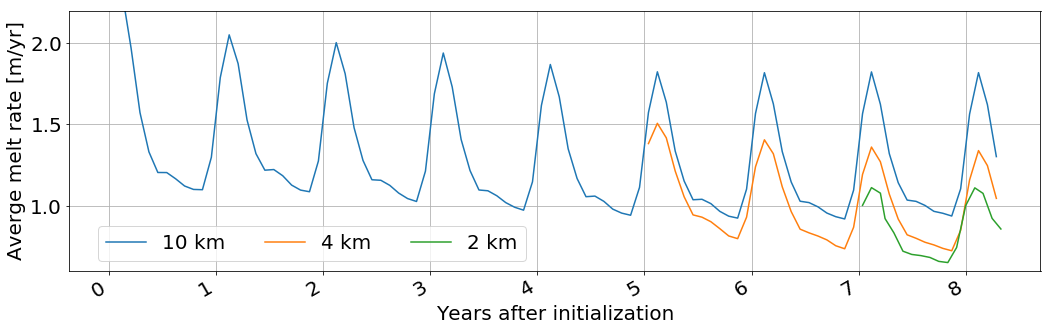

In [71]:
out_path = os.path.join(proj_dir,'reports','devel','figures','mass_loss_spinup.png')
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.size': 20})

plt.close()
fig,ax = plt.subplots(figsize=(15,5))
ismr10.plot(label='10 km',ax=ax)
ismr4.plot(label='4 km',ax=ax)
ismr2_hack.plot(label='2 km',ax=ax)
ax.set_ylim(0.6,2.2)
#ax.set_xlim(0,10)
#ax.set_title('Area average melt rate (m/yr)',fontsize=24)
ax.grid()
ax.set_ylabel('Averge melt rate [m/yr]')
ax.set_xlabel('Years after initialization')
ax.set_xticklabels(range(9))
ax.legend(markerscale=1,loc='lower center', bbox_to_anchor=(0.25, 0),ncol=3)
plt.savefig(out_path)
plt.show()

In [51]:
waom2_path = os.path.join(data_dir,'raw','waom2_fix','ocean_avg_06??.nc')
avg2_2 = xr.open_mfdataset(waom2_path,chunks={'eta_rho':150,'xi_rho':150})

In [76]:

avg2_5d = xr.concat([avg2,avg2_2])
bmb2,ismr2,mask2 = total_bmb(avg2_5d,grd2,vostock2,time)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  """Entry point for launching an IPython kernel.
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/core.py:3468: PerformanceWarning: Increasing number of chunks by factor of 18
  **atop_kwargs)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/dask/array/core.py:3468: PerformanceWarning: Increasing number of chunks by factor of 21
  **atop_kwargs)


In [81]:
ismr2.ocean_time


<xarray.DataArray 'ocean_time' (ocean_time: 75)>
array(['2014-04-11T12:00:00.000000000', '2014-04-16T12:00:00.000000000',
       '2014-04-21T12:00:00.000000000', '2014-04-26T12:00:00.000000000',
       '2014-05-01T12:00:00.000000000', '2014-05-06T12:00:00.000000000',
       '2014-05-11T12:00:00.000000000', '2014-05-16T12:00:00.000000000',
       '2014-05-21T12:00:00.000000000', '2014-05-26T12:00:00.000000000',
       '2014-05-31T12:00:00.000000000', '2014-06-05T12:00:00.000000000',
       '2014-06-10T12:00:00.000000000', '2014-06-15T12:00:00.000000000',
       '2014-06-20T12:00:00.000000000', '2014-06-25T12:00:00.000000000',
       '2014-06-30T12:00:00.000000000', '2014-07-05T12:00:00.000000000',
       '2014-07-10T12:00:00.000000000', '2014-07-15T12:00:00.000000000',
       '2014-07-20T12:00:00.000000000', '2014-07-25T12:00:00.000000000',
       '2014-07-30T12:00:00.000000000', '2014-08-04T12:00:00.000000000',
       '2014-08-09T12:00:00.000000000', '2014-08-14T12:00:00.000000000',
  

In [70]:
m2_1MS = avg2_5d.m.resample(ocean_time='1MS').mean()
m2_1MS.ocean_time

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:43064 remote=tcp://127.0.0.1:59503>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:43065 remote=tcp://127.0.0.1:59503>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:43066 remote=tcp://127.0.0.1:59503>


<xarray.DataArray 'ocean_time' (ocean_time: 13)>
array(['2014-04-01T00:00:00.000000000', '2014-05-01T00:00:00.000000000',
       '2014-06-01T00:00:00.000000000', '2014-07-01T00:00:00.000000000',
       '2014-08-01T00:00:00.000000000', '2014-09-01T00:00:00.000000000',
       '2014-10-01T00:00:00.000000000', '2014-11-01T00:00:00.000000000',
       '2014-12-01T00:00:00.000000000', '2015-01-01T00:00:00.000000000',
       '2015-02-01T00:00:00.000000000', '2015-03-01T00:00:00.000000000',
       '2015-04-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-04-01 2014-05-01 2014-06-01 ...

In [75]:
m2_mth = avg2.m.groupby('ocean_time.month').mean("ocean_time")
out_path = '~/raijin/g/data2/gh9/oxr581/waom2/m2_mth.nc'
m2_mth.to_netcdf(out_path)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:43102 remote=tcp://127.0.0.1:59503>
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 6.58 MB detected in task graph: 
  ("('transpose-f0e80dd165818ec3db0e37b93550ad50', 0 ... 82e8>]), False)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 1234 was killed by unknown signal
distributed.nanny 

In [13]:
ismr2_mnt = ismr2.sel(ocean_time='2014').groupby('ocean_time.month').mean("ocean_time")
ismr2_mnt = ismr2_mnt.to_dataset(name='ismr2').rename({'month':'ocean_time'})
ismr2_mnt

<xarray.Dataset>
Dimensions:     (ocean_time: 9)
Coordinates:
  * ocean_time  (ocean_time) int64 4 5 6 7 8 9 10 11 12
Data variables:
    ismr2       (ocean_time) float64 dask.array<shape=(9,), chunksize=(1,)>

In [14]:
ismr2_mnt['ocean_time'] = ismr4.ocean_time.sel(ocean_time=slice('2014-4','2014-12'))
ismr2_mnt = ismr2_mnt.ismr2